In [7]:

from backend.pytorch import DET_ARCHS, RECO_ARCHS, forward_image, load_predictor
from doctr.io import DocumentFile
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import streamlit as st
import torch
from backend.pytorch import DET_ARCHS, RECO_ARCHS, forward_image, load_predictor
from doctr.utils.visualization import visualize_page


doc_path = "../data/mydata/flight.png"
if doc_path.endswith((".pdf", ".PDF")):
    doc = DocumentFile.from_pdf(doc_path)
else:
    doc = DocumentFile.from_images(doc_path)
page = doc[0]

forward_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

predictor = load_predictor(
    det_arch=DET_ARCHS[0],
    reco_arch=RECO_ARCHS[0],
    assume_straight_pages=True,
    straighten_pages=False,
    export_as_straight_boxes=False,
    disable_page_orientation=False,
    disable_crop_orientation=False,
    bin_thresh=0.3,
    box_thresh=0.1,
    device=forward_device,
)

# Forward the image to the model
seg_map = forward_image(predictor, page, forward_device)
seg_map = np.squeeze(seg_map)
seg_map = cv2.resize(seg_map, (page.shape[1], page.shape[0]), interpolation=cv2.INTER_LINEAR)

# Run OCR
out = predictor([page])
page_export = out.pages[0].export()
img = out.pages[0].synthesize()

In [ ]:
import cv2
from doclayout_yolo import YOLOv10
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import pipeline
import logging


def detect_text_yolo(page):
    """Detect text regions in an image using YOLOv10 model.
    Args:
        page: Input image as a NumPy array.
    Returns:
        det_res: Detection results from the YOLOv10 model.
    """
    # Load the pre-trained model
    model = YOLOv10("../models/yolo.pt")

    # Perform prediction
    det_res = model.predict(
        page,   # Image to predict
        imgsz=1024,        # Prediction image size
        conf=0.2,          # Confidence threshold
        device="mps"
    )

    return det_res


def box_area(box):
    # box = [x1, y1, x2, y2]
    return max(0, box[2] - box[0]) * max(0, box[3] - box[1])


def intersection_area(word_box, big_box):
    x1 = max(word_box[0][0], big_box[0])
    y1 = max(word_box[0][1], big_box[1])
    x2 = min(word_box[1][0], big_box[2])
    y2 = min(word_box[1][1], big_box[3])

    if x2 <= x1 or y2 <= y1:
        return 0
    return (x2 - x1) * (y2 - y1)


def get_big_boxes(page_export, det_res):
    big_boxes = det_res[0].boxes.xyxyn.tolist()
    big_boxes_children = [[] for _ in big_boxes]

    for idx, line in enumerate(page_export['blocks'][0]['lines']):
        for word in line['words']:
            word_box = word['geometry']
            word_area = box_area(
                [word_box[0][0], word_box[0][1], word_box[1][0], word_box[1][1]])

            candidates = []

            # Find all boxes with >= 75% overlap
            for i, box in enumerate(big_boxes):
                inter_area = intersection_area(word_box, box)
                overlap_ratio = inter_area / (word_area + 1e-8)

                if overlap_ratio >= 0.75:
                    candidates.append((i, overlap_ratio, box_area(box)))

            if candidates:
                # Sort by:
                #   1) highest overlap
                #   2) smallest big-box area (closest fit)
                candidates.sort(key=lambda x: (x[2]))

                best_match = candidates[0][0]

                word['line_id'] = idx
                big_boxes_children[best_match].append(word)
            else:
                print("No 75% match:", word)
    return big_boxes, big_boxes_children


def get_line(box, geometry):
    text = ""
    for child in box:
        text += child['value'] + " "
    geometry = ((np.float32(geometry[0]), np.float32(
        geometry[1])), (np.float32(geometry[2]), np.float32(geometry[3])))
    num_lines = len(set([child['line_id'] for child in box]))
    return {
        "geometry": geometry,
        "num_lines": num_lines,
        "words": [
            {
                "confidence": 1,
                "crop_orientation": {
                    'value': 0,
                    'confidence':  None
                },
                "value": text.strip(),
                "geometry": geometry
            }]
    }


def update_page_with_layout(page, page_export):
    det_res = detect_text_yolo(page)
    big_boxes, big_boxes_children = get_big_boxes(page_export, det_res)
    types = det_res[0].boxes.data[:, -1].int().cpu()
    mask = (0, 1, 4, 6, 7, 9)
    types = torch.isin(types, torch.tensor(mask))
    lines = [get_line(big_boxes_children[i], big_boxes[i]) for i in range(
        len(big_boxes)) if big_boxes_children[i] and types[i]]
    page_export['blocks'][0]['lines'] = lines
    return page_export


def translate_lines(page_export):
    translator = pipeline("translation", model="facebook/nllb-200-distilled-600M", src_lang="eng_Latn", tgt_lang="mal_Mlym")
    values = []
    for block in page_export['blocks']:
        for line in block['lines']:
            if len(line['words']) > 1:
                logging.warning("More than 1 word in line")
            for word in line['words']:
                values.append(word['value'])
    translations = translator(values)
    for block in page_export['blocks']:
        for line in block['lines']:
            for word in line['words']:
                word['value'] = translations.pop(0)['translation_text']
    return page_export




page_export = update_page_with_layout(page, page_export)


0: 1024x864 10 titles, 18 plain texts, 6 abandons, 7 figures, 2 figure_captions, 73.7ms
Speed: 6.8ms preprocess, 73.7ms inference, 4.5ms postprocess per image at shape (1, 3, 1024, 864)
No 75% match: {'value': 'Check', 'confidence': 0.9977310299873352, 'geometry': ((np.float64(0.07062679597701149), np.float64(0.3857421875)), (np.float64(0.11885775862068965), np.float64(0.400390625))), 'objectness_score': 0.7614503502845764, 'crop_orientation': {'value': 0, 'confidence': None}}
No 75% match: {'value': 'in', 'confidence': 0.9993526339530945, 'geometry': ((np.float64(0.11885775862068965), np.float64(0.384765625)), (np.float64(0.13532686781609193), np.float64(0.3994140625))), 'objectness_score': 0.7371227741241455, 'crop_orientation': {'value': 0, 'confidence': None}}
No 75% match: {'value': 'online,', 'confidence': 0.5804396867752075, 'geometry': ((np.float64(0.1365032327586207), np.float64(0.3857421875)), (np.float64(0.18826329022988508), np.float64(0.400390625))), 'objectness_score': 0

In [18]:
page_export = translate_lines(page_export)

Device set to use mps:0


(np.float64(-0.5), np.float64(1739.5), np.float64(2095.5), np.float64(-0.5))

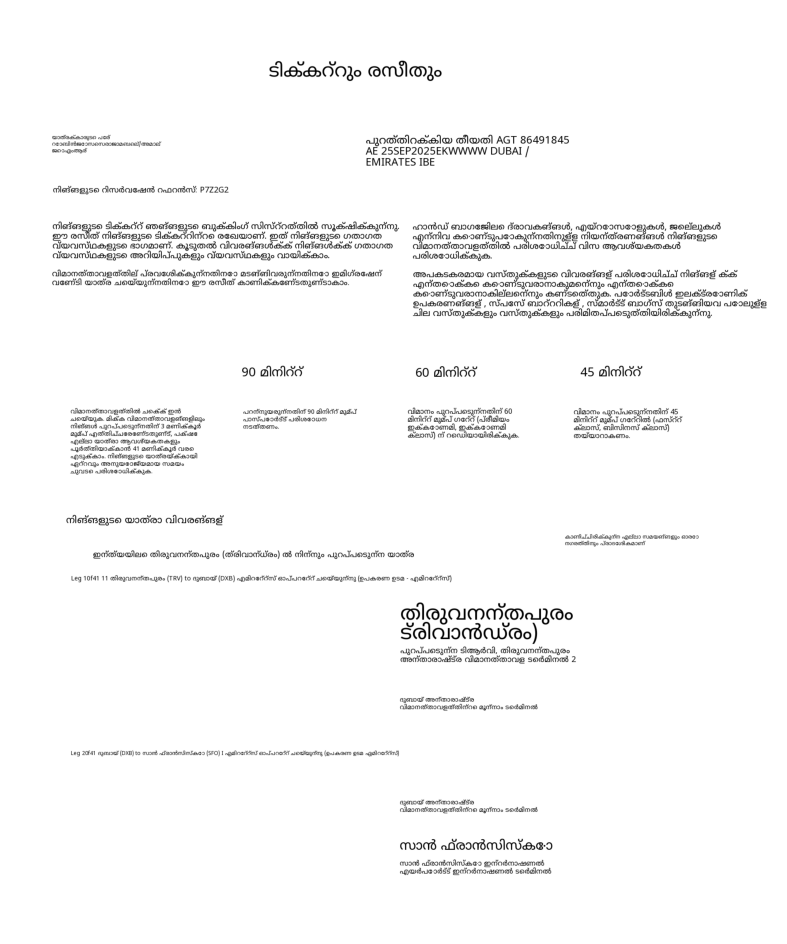

In [19]:

from utils import synthesize_page
syn = synthesize_page(page_export, font_family="../fonts/noto-mal.ttf")
plt.figure(figsize=(12, 12))
plt.imshow(syn)
plt.axis('off')

In [23]:
for line in page_export['blocks'][0]['lines']:
    if len(line['words']) > 1:
        print(("Line: "))
    for word in line['words']:
        print(word['value'])

നിങ്ങളുടെ ടിക്കറ്റ് ഞങ്ങളുടെ ബുക്കിംഗ് സിസ്റ്റത്തിൽ സൂക്ഷിക്കുന്നു. ഈ രസീത് നിങ്ങളുടെ ടിക്കറ്റിന്റെ രേഖയാണ്. ഇത് നിങ്ങളുടെ ഗതാഗത വ്യവസ്ഥകളുടെ ഭാഗമാണ്. കൂടുതൽ വിവരങ്ങൾക്ക് നിങ്ങൾക്ക് ഗതാഗത വ്യവസ്ഥകളുടെ അറിയിപ്പുകളും വ്യവസ്ഥകളും വായിക്കാം.
അപകടകരമായ വസ്തുക്കളുടെ വിവരങ്ങള് പരിശോധിച്ച് നിങ്ങള് ക്ക് എന്തൊക്കെ കൊണ്ടുവരാനാകുമെന്നും എന്തൊക്കെ കൊണ്ടുവരാനാകില്ലെന്നും കണ്ടെത്തുക. പോർട്ടബിൾ ഇലക്ട്രോണിക് ഉപകരണങ്ങള് , സ്പേസ് ബാറ്ററികള് , സ്മാർട്ട് ബാഗ്സ് തുടങ്ങിയവ പോലുള്ള ചില വസ്തുക്കളും വസ്തുക്കളും പരിമിതപ്പെടുത്തിയിരിക്കുന്നു.
ഹാൻഡ് ബാഗേജിലെ ദ്രാവകങ്ങൾ, എയ്റോസോളുകൾ, ജെല്ലുകൾ എന്നിവ കൊണ്ടുപോകുന്നതിനുള്ള നിയന്ത്രണങ്ങൾ നിങ്ങളുടെ വിമാനത്താവളത്തിൽ പരിശോധിച്ച് വിസ ആവശ്യകതകൾ പരിശോധിക്കുക.
വിമാനത്താവളത്തില് പ്രവേശിക്കുന്നതിനോ മടങ്ങിവരുന്നതിനോ ഇമിഗ്രേഷന് വേണ്ടി യാത്ര ചെയ്യുന്നതിനോ ഈ രസീത് കാണിക്കേണ്ടതുണ്ടാകാം.
വിമാനത്താവളത്തിൽ ചെക്ക് ഇൻ ചെയ്യുക. മിക്ക വിമാനത്താവളങ്ങളിലും നിങ്ങൾ പുറപ്പെടുന്നതിന് 3 മണിക്കൂർ മുമ്പ് എത്തിച്ചേരേണ്ടതുണ്ട്, പക്ഷേ എല്ലാ യാത്രാ ആവശ്യകതകളും പൂർത്തിയാക്കാൻ 41 മണിക്കൂർ വരെ എടുക്കാം. ന